
## REGRESSÃO COM UMA VARIÁVEL EXPLICATIVA (X) QUALITATIVA

In [1]:
# Importação dos pacotes
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go # gráficos 3D
from scipy.stats import pearsonr # correlações de Pearson
import statsmodels.api as sm # estimação de modelos
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from sklearn.preprocessing import LabelEncoder # transformação de dados
from playsound import playsound # reprodução de sons
import pingouin as pg # outro modo para obtenção de matrizes de correlações
import emojis # inserção de emojis em gráficos
from statstests.process import stepwise # procedimento Stepwise
from statstests.tests import shapiro_francia # teste de Shapiro-Francia
from scipy.stats import boxcox # transformação de Box-Cox
from scipy.stats import norm # para plotagem da curva normal
from scipy import stats # utilizado na definição da função 'breusch_pagan_test'

import networkx as nx
import matplotlib.cm as cm

playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [2]:
df_corrupcao = pd.read_csv('/home/usp_ds_analytics/regression_analysis/data/corrupcao.csv',delimiter=',',encoding='utf-8')
df_corrupcao.head()

,pais,cpi,regiao
0,Argentina,3.9,America_do_sul
1,Australia,8.7,Oceania
2,Austria,7.9,Europa
3,Belgium,7.1,Europa
4,Brazil,4.0,America_do_sul


Vamos trabalhar `cpi` (quanti) em função da `regiao` (quali)

In [3]:
df_corrupcao.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pais    50 non-null     object 
 1   cpi     50 non-null     float64
 2   regiao  50 non-null     object 
dtypes: float64(1), object(2)
memory usage: 1.3+ KB


In [4]:
df_corrupcao.describe()

,cpi
count,50.000000
mean,4.894000
std,2.678974
min,0.800000
25%,2.575000
50%,3.950000
75%,7.475000
max,9.300000


In [5]:
# Estatística variável por regiao
df_corrupcao.groupby('regiao').describe()

cpi                                                  
               count      mean       std  min    25%   50%    75%  max
regiao                                                                
America_do_sul   5.0  4.180000  1.237740  2.8  3.900  4.00  4.000  6.2
Asia            17.0  2.329412  0.898446  0.8  1.800  2.30  2.800  3.8
EUA_e_Canada     2.0  8.000000  1.272792  7.1  7.550  8.00  8.450  8.9
Europa          24.0  6.258333  2.272504  2.1  4.275  6.55  8.125  9.3
Oceania          2.0  9.000000  0.424264  8.7  8.850  9.00  9.150  9.3

In [15]:
# Para avaliar apenas a média do cpi para cada regiao agrupada
df_corrupcao.groupby('regiao')['cpi'].mean().reset_index()

,regiao,cpi
0,America_do_sul,4.180000
1,Asia,2.329412
2,EUA_e_Canada,8.000000
3,Europa,6.258333
4,Oceania,9.000000


In [6]:
# Contagem dos valores absolutos e percentuais
contagem = df_corrupcao['regiao'].value_counts(dropna=False)
percent = df_corrupcao['regiao'].value_counts(dropna=False, normalize=True)
pd.concat([contagem, percent], axis=1, keys=['contagem', '%'], sort=False)

,contagem,%
regiao,,
Europa,24,0.48
Asia,17,0.34
America_do_sul,5,0.10
Oceania,2,0.04
EUA_e_Canada,2,0.04


### O erro que muitos cometem: ponderação arbitrária.
Considerar as categorias como números inteiros.
Nem sempre uma categoria para outra terá o mesmo salto, o mesmo peso, então precisamos tomar muito cuidado com isso!

In [7]:
# In[3.2]: Conversão dos dados de 'regiao' para dados numéricos, a fim de
#se mostrar a estimação de modelo com o problema da ponderação arbitrária
label_encoder = LabelEncoder()
df_corrupcao['regiao_numerico'] = label_encoder.fit_transform(df_corrupcao['regiao'])
# Para começar a partir do 1, e não do 0
df_corrupcao['regiao_numerico'] = df_corrupcao['regiao_numerico'] + 1
df_corrupcao.head(10)

,pais,cpi,regiao,regiao_numerico
0,Argentina,3.9,America_do_sul,1
1,Australia,8.7,Oceania,5
2,Austria,7.9,Europa,4
3,Belgium,7.1,Europa,4
4,Brazil,4.0,America_do_sul,1
5,Canada,8.9,EUA_e_Canada,3
6,Chile,6.2,America_do_sul,1
7,China,2.5,Asia,2
8,Colombia,4.0,America_do_sul,1
9,Cyprus,6.3,Europa,4


A nova variável 'regiao_numerico' é quantitativa (ERRO!), fato que
caracteriza a ponderação arbitrária!

In [8]:
df_corrupcao['regiao_numerico'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50 entries, 0 to 49
Series name: regiao_numerico
Non-Null Count  Dtype
--------------  -----
50 non-null     int64
dtypes: int64(1)
memory usage: 532.0 bytes


In [9]:
df_corrupcao['regiao_numerico'].describe()

count    50.000000
mean      3.020000
std       1.186489
min       1.000000
25%       2.000000
50%       4.000000
75%       4.000000
max       5.000000
Name: regiao_numerico, dtype: float64

#### PONDERAÇÃO ARBITRÁRIA

In [10]:
# In[3.3]: Modelando com a variável preditora numérica, resultando na
#estimação ERRADA dos parâmetros
modelo_corrupcao_errado = sm.OLS.from_formula('cpi ~ regiao_numerico',
                                              df_corrupcao).fit()

In [11]:
modelo_corrupcao_errado.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cpi   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.399
Method:                 Least Squares   F-statistic:                     33.56
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           5.19e-07
Time:                        15:25:32   Log-Likelihood:                -106.46
No. Observations:                  50   AIC:                             216.9
Df Residuals:                      48   BIC:                             220.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5200      0.810      0.642      0.524      -1.109       2.149
regiao_numerico     1.4483      0.250      5.793      0.000       0.946       1.951
==============================================================================
Omnibus:                        2.392   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.302   Jarque-Bera (JB):                1.392
Skew:                           0.027   Prob(JB):                        0.499
Kurtosis:                       2.184   Cond. No.                         9.69
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Vimos aqui que estatisticamente ele passou, mas será mesmo que mostra a realidade?

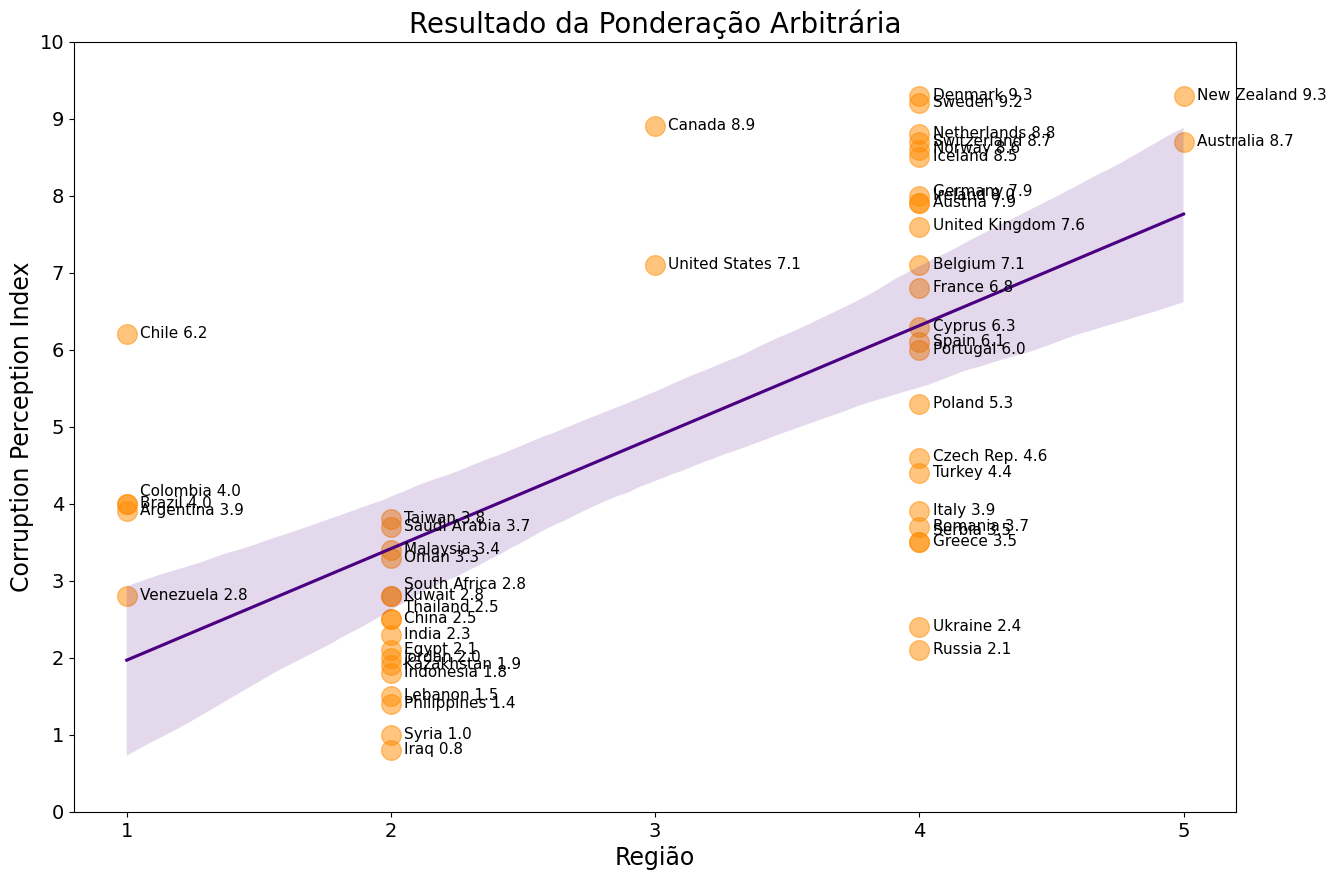

In [12]:
# In[3.4]: Plotando os fitted values do 'modelo_corrupcao_errado' considerando,
#PROPOSITALMENTE, a ponderação arbitrária, ou seja, assumindo que as regiões
#representam valores numéricos (América do Sul = 1; Ásia = 2; EUA e Canadá = 3;
#Europa = 4; Oceania = 5)
plt.figure(figsize=(15,10))

ax =sns.regplot(
    data=df_corrupcao,
    x="regiao_numerico", y="cpi",
    scatter_kws={"s": 200, "color": "darkorange", "alpha": 0.5},
    line_kws={"color": "indigo"}
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        offset = 0
        while ax.texts:
            overlapping = False
            for text in ax.texts:
                overlapping |= text.get_position()[0] == (point['x'] + 0.05) and text.get_position()[1] == (point['y'] - 0.05 + offset)
            if overlapping:
                offset += 0.15
            else:
                break
        ax.annotate(str(point['val']) + " " + str(point['y']),
                    (point['x'] + 0.05,
                     point['y'] - 0.05 + offset),
                    fontsize=11)
                
plt.title('Resultado da Ponderação Arbitrária', fontsize=20)
plt.xlabel('Região', fontsize=17)
plt.ylabel('Corruption Perception Index', fontsize=17)
plt.xticks(range(1, 6, 1), fontsize=14)
plt.yticks(range(0, 11, 1), fontsize=14)
label_point(x = df_corrupcao['regiao_numerico'],
            y = df_corrupcao['cpi'],
            val = df_corrupcao['pais'],
            ax = plt.gca())
plt.show()


### Dummizando a variável 'regiao' - a maneira correta de trabalhar
    a) o estabelecimento de dummies que representarão cada uma das regiões do dataset;
    b) removerá a variável original a partir da qual houve a dummização;
    c) estabelecerá como categoria de referência a primeira categoria, ou seja, a categoria 'America_do_sul' por meio do argumento 'drop_first=True'

In [13]:
df_corrupcao_dummies = pd.get_dummies(df_corrupcao, columns=['regiao'],
                                      dtype=int,
                                      drop_first=True) # n dummies

df_corrupcao_dummies.head()

,pais,cpi,regiao_numerico,regiao_Asia,regiao_EUA_e_Canada,regiao_Europa,regiao_Oceania
0,Argentina,3.9,1,0,0,0,0
1,Australia,8.7,5,0,0,0,1
2,Austria,7.9,4,0,0,1,0
3,Belgium,7.1,4,0,0,1,0
4,Brazil,4.0,1,0,0,0,0


In [14]:
# A variável 'regiao' estava inicialmente definida como 'object' no dataframe
df_corrupcao['regiao'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 50 entries, 0 to 49
Series name: regiao
Non-Null Count  Dtype 
--------------  ----- 
50 non-null     object
dtypes: object(1)
memory usage: 532.0+ bytes


Este procedimento de dummização também poderia ter sido realizado em uma variável do tipo 'category' ou 'string'!

Categoria referência: é a categoria que ele considera como referência, com base nela 0 representa ausência e 1 presença.

Categoria alternativa: todas as demais

### Estimação do modelo

In [18]:
modelo_corrupcao_dummies = sm.OLS.from_formula('cpi ~ regiao_Asia + \
                                               regiao_EUA_e_Canada + \
                                               regiao_Europa + \
                                               regiao_Oceania',
                                               df_corrupcao_dummies).fit()

modelo_corrupcao_dummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           1.37e-08
Time:                        15:46:53   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.1800      0.788      5.306      0.000       2.593       5.767
regiao_Asia            -1.8506      0.896     -2.065      0.045      -3.655      -0.046
regiao_EUA_e_Canada     3.8200      1.474      2.592      0.013       0.852       6.788
regiao_Europa           2.0783      0.866      2.400      0.021       0.334       3.822
regiao_Oceania          4.8200      1.474      3.271      0.002       1.852       7.788
==============================================================================
Omnibus:                        1.205   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                1.083
Skew:                          -0.347   Prob(JB):                        0.582
Kurtosis:                       2.804   Cond. No.                         9.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Outro método de estimação (sugestão de uso para muitas dummies no dataset).
Ao invés de incluir, fazemos o drop da coluna que desejamos que seja a referência.

In [21]:
lista_colunas = list(df_corrupcao_dummies.drop(columns=['cpi','pais',
                                                        'regiao_numerico']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "cpi ~ " + formula_dummies_modelo

# Estimação
modelo_corrupcao_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_corrupcao_dummies).fit()

# Parâmetros do 'modelo_corrupcao_dummies'
modelo_corrupcao_dummies.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cpi   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     17.09
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           1.37e-08
Time:                        16:05:39   Log-Likelihood:                -96.620
No. Observations:                  50   AIC:                             203.2
Df Residuals:                      45   BIC:                             212.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               4.1800      0.788      5.306      0.000       2.593       5.767
regiao_Asia            -1.8506      0.896     -2.065      0.045      -3.655      -0.046
regiao_EUA_e_Canada     3.8200      1.474      2.592      0.013       0.852       6.788
regiao_Europa           2.0783      0.866      2.400      0.021       0.334       3.822
regiao_Oceania          4.8200      1.474      3.271      0.002       1.852       7.788
==============================================================================
Omnibus:                        1.205   Durbin-Watson:                   1.928
Prob(Omnibus):                  0.547   Jarque-Bera (JB):                1.083
Skew:                          -0.347   Prob(JB):                        0.582
Kurtosis:                       2.804   Cond. No.                         9.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Mudando a categoria de referência

In [16]:
# Categoria de referência = Oceania

# Definição da fórmula utilizada no modelo
lista_colunas = list(df_corrupcao_dummies.drop(columns=['cpi','pais',
                                                        'regiao_numerico',
                                                        'regiao_Oceania']).columns)
formula_dummies_modelo = ' + '.join(lista_colunas)
formula_dummies_modelo = "cpi ~ " + formula_dummies_modelo
print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  cpi ~ regiao_Asia + regiao_EUA_e_Canada + regiao_Europa


In [17]:
# Estimação
modelo_corrupcao_dummies = sm.OLS.from_formula(formula_dummies_modelo,
                                               df_corrupcao_dummies).fit()

# Parâmetros do 'modelo_corrupcao_dummies'
modelo_corrupcao_dummies.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cpi   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.477
Method:                 Least Squares   F-statistic:                     15.87
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           3.20e-07
Time:                        15:42:58   Log-Likelihood:                -101.95
No. Observations:                  50   AIC:                             211.9
Df Residuals:                      46   BIC:                             219.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.5571      0.733      7.586      0.000       4.083       7.032
regiao_Asia            -3.2277      0.870     -3.708      0.001      -4.980      -1.476
regiao_EUA_e_Canada     2.4429      1.554      1.572      0.123      -0.685       5.571
regiao_Europa           0.7012      0.833      0.842      0.404      -0.975       2.377
==============================================================================
Omnibus:                        0.786   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.675   Jarque-Bera (JB):                0.810
Skew:                          -0.112   Prob(JB):                        0.667
Kurtosis:                       2.418   Cond. No.                         7.48
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Plotando o 'modelo_corrupcao_dummies' de forma interpolada

In [24]:
# Fitted values do 'modelo_corrupcao_dummies' no dataset 'df_corrupcao_dummies'
df_corrupcao_dummies['fitted'] = modelo_corrupcao_dummies.fittedvalues
df_corrupcao_dummies.tail()

,pais,cpi,regiao_numerico,regiao_Asia,regiao_EUA_e_Canada,regiao_Europa,regiao_Oceania,fitted
45,United States,7.1,3,0,1,0,0,8.000000
46,Venezuela,2.8,1,0,0,0,0,4.180000
47,Jordan,2.0,2,1,0,0,0,2.329412
48,Syria,1.0,2,1,0,0,0,2.329412
49,Iraq,0.8,2,1,0,0,0,2.329412


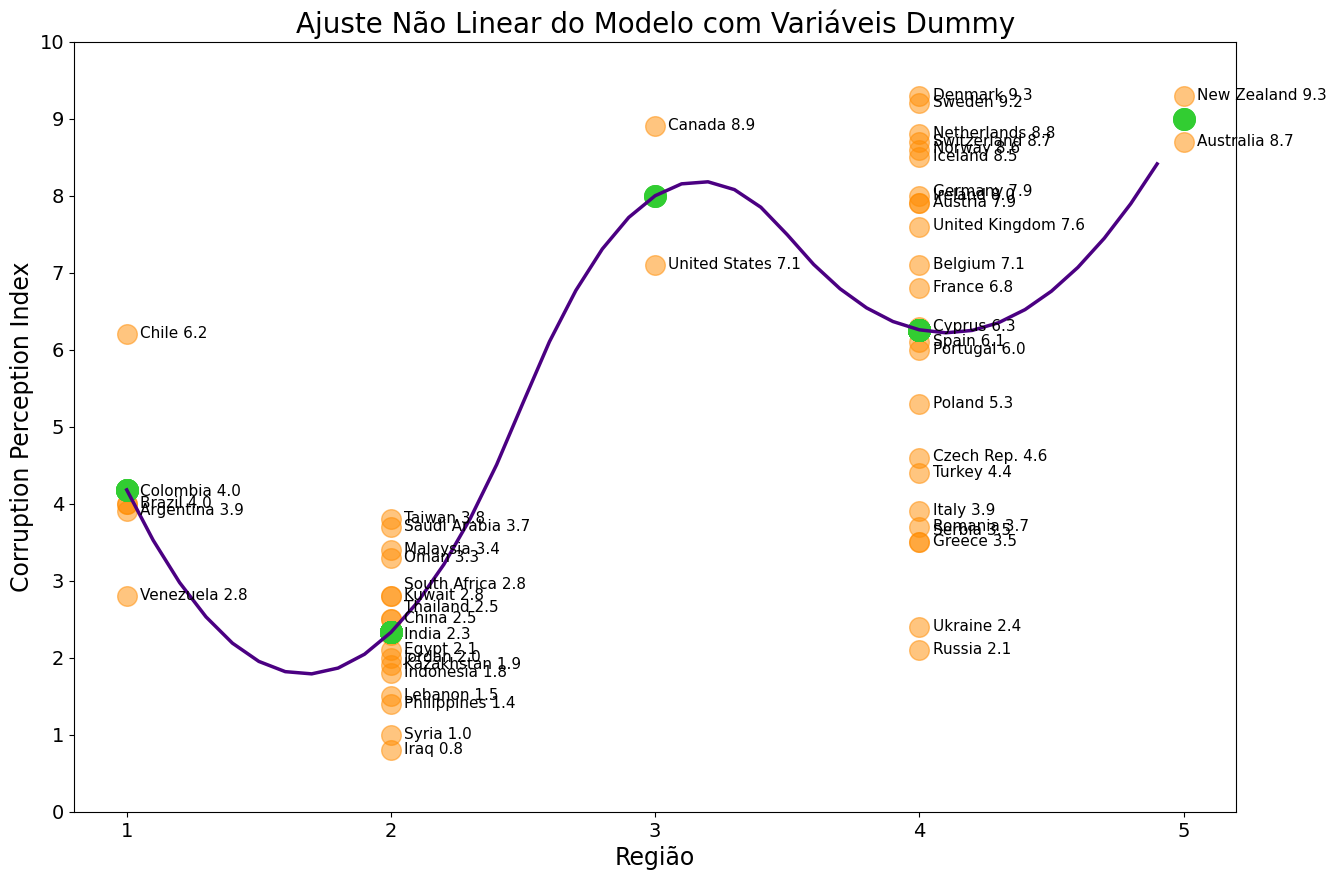

In [25]:
from scipy import interpolate

plt.figure(figsize=(15, 10))

df2 = df_corrupcao_dummies[['regiao_numerico',
                            'fitted']].groupby(['regiao_numerico']).median().reset_index()
x = df2['regiao_numerico']
y = df2['fitted']

tck = interpolate.splrep(x, y, k=2)
xnew = np.arange(1, 5, 0.1)
ynew = interpolate.splev(xnew, tck, der=0)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        offset = 0
        while ax.texts:
            overlapping = False
            for text in ax.texts:
                overlapping |= text.get_position()[0] == (point['x'] + 0.05) and text.get_position()[1] == (point['y'] - 0.05 + offset)
            if overlapping:
                offset += 0.15
            else:
                break
        ax.annotate(str(point['val']) + " " + str(point['y']),
                    (point['x'] + 0.05,
                     point['y'] - 0.05 + offset),
                    fontsize=11)

plt.scatter(df_corrupcao_dummies['regiao_numerico'],
            df_corrupcao_dummies['cpi'], color='darkorange', s=200, alpha=0.5)
plt.scatter(df_corrupcao_dummies['regiao_numerico'],
            df_corrupcao_dummies['fitted'], color='limegreen', s=240)
plt.plot(xnew, ynew, color='indigo', linewidth=2.5)
plt.title('Ajuste Não Linear do Modelo com Variáveis Dummy', fontsize=20)
plt.xlabel('Região', fontsize=17)
plt.ylabel('Corruption Perception Index', fontsize=17)
plt.xticks(range(1, 6, 1), fontsize=14)
plt.yticks(range(0, 11, 1), fontsize=14)
label_point(x=df_corrupcao_dummies['regiao_numerico'],
            y=df_corrupcao_dummies['cpi'],
            val=df_corrupcao_dummies['pais'],
            ax=plt.gca())
plt.show()

### Gráfico interativo

In [26]:
df2 = df_corrupcao_dummies[['regiao_numerico',
                            'fitted']].groupby(['regiao_numerico']).median().reset_index()
x = df2['regiao_numerico']
y = df2['fitted']

tck = interpolate.splrep(x, y, k=2)
xnew = np.arange(1, 5, 0.1)
ynew = interpolate.splev(xnew, tck, der=0)

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_corrupcao_dummies['regiao_numerico'],
    y=df_corrupcao_dummies['cpi'],
    mode='markers',
    name='CPI',
    marker=dict(color='darkorange', size=14, opacity=0.5)
))

fig.add_trace(go.Scatter(
    x=df_corrupcao_dummies['regiao_numerico'],
    y=df_corrupcao_dummies['fitted'],
    mode='markers',
    name='Fitted',
    marker=dict(color='limegreen', size=17)
))

fig.add_trace(go.Scatter(
    x=xnew,
    y=ynew,
    mode='lines',
    name='Interpolated',
    line=dict(color='indigo', width=3.5)
))

fig.update_layout(title={
        'text': 'Ajuste Não Linear do Modelo com Variáveis Dummy',
        'font': {'size': 20, 'color': 'black', 'family': 'Arial'},
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis=dict(title='Região'),
    yaxis=dict(title='Corruption Perception Index'),
    xaxis_tickvals=list(range(1, 6)),
    yaxis_tickvals=list(range(0, 11)),
    xaxis_tickfont=dict(size=14),
    yaxis_tickfont=dict(size=14),
    template='plotly_white')

for i in range(len(df_corrupcao_dummies)):
    fig.add_annotation(
        x=df_corrupcao_dummies['regiao_numerico'][i],
        y=df_corrupcao_dummies['cpi'][i],
        text=str(df_corrupcao_dummies['pais'][i]) + ' ' + str(df_corrupcao_dummies['cpi'][i]),
        showarrow=False,
        font=dict(size=11, color='black'),
        xshift=50,
        yshift=0,
        textangle=0
    )

fig.update_annotations(dict(xref="x", yref="y"))
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.write_html('EXEMPLO3.html')

# Abre o arquivo HTML no browser
import webbrowser
webbrowser.open('EXEMPLO3.html')

True